<div style="
    background-color: #E6F7FF; 
    border-left: 5px solid #007bff; 
    border-radius: 8px; 
    padding: 15px; 
    box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1); 
    color: #000000;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    text-align: center;
">
<h1> Predicting Diabetes Risk: A Binary Classification Challenge </h1>
</div>

<div style="
    background-color: #E6F7FF; 
    border-left: 5px solid #007bff; 
    border-radius: 8px; 
    padding: 15px; 
    box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1); 
    color: #000000;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    text-align: center;
">
<p> 
This project focuses on a Binary Classification challenge using synthetically-generated tabular data from the Kaggle Tabular Playground Series (December 2025). The core objective is to develop a robust machine learning model capable of predicting the probability that a patient will be diagnosed with diabetes.

The success of the solution is measured by the Area Under the ROC Curve (AUC). Given the nature of medical diagnosis data, the analysis requires a strong emphasis on Exploratory Data Analysis (EDA), careful handling of potential class imbalance, and sophisticated feature engineering to derive maximum predictive signal from the dataset.

Key methods implemented include: data cleaning and transformation, utilizing advanced classification algorithms (such as Gradient Boosting Machines or deep learning models) for high predictive power, and systematic hyperparameter tuning to optimize performance specifically against the AUC metric. The final deliverable is a set of strategic insights and a high-accuracy probability submission file.
</p>
</div>

In [1]:
# import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm.notebook import tqdm
import warnings
import random
import optuna

warnings.simplefilter("ignore")

In [2]:
# Static Variable.
train_filepath = "/kaggle/input/playground-series-s5e12/train.csv"
test_filepath = "/kaggle/input/playground-series-s5e12/test.csv"
random_state = 42
target = "diagnosed_diabetes"
test_size = 0.2

In [3]:
def style_column_headers(df):
    
    # Define the CSS styles for the header (<th> tag)
    header_styles = [
        {
            # Apply to ALL column headers
            'selector': 'th',
            'props': [
                ('background-color', '#E6F7FF'),  # Dark Green background
                ('color', '#004085'),              # White text color
                ('font-family', 'sans-serif'),   # Clean font
                ('font-size', '14px'),
                ('text-align', 'center'),
                ('border', '1px solid black')    # Add a border
            ]
        }
    ]
    
    # Apply the styles and render the DataFrame
    return df.style.set_table_styles(header_styles)

In [4]:
# Create a function to handle or the processing of the data.
def process(filepath:str, transform=False)->pd.DataFrame:
    "This reads the csv file and transform it where neccessary"
    # Read the csv filepath.
    df = pd.read_csv(filepath, index_col= "id")

    # control flow.
    if transform:
        transformation = {}
        # Starting with age 
        df["age_group"] = pd.cut(df["age"], 3, labels=["Youth", "Adult", "Elderly"]).astype("object")
        transformation["age_group"] = "Age is Grouped into 3 categories"

        df["cholesterol_unkown"] = (df["cholesterol_total"] - (df["hdl_cholesterol"] + df["ldl_cholesterol"]))
        transformation["cholesterol_unknown"] = "Unknown Cholesterol"

        df["bp_diff"] = (df["systolic_bp"] - df["diastolic_bp"])
        transformation["bp_diff"] = "Blood Pressure Difference"

        df["smoking_status"] = df["smoking_status"].replace({"Never": 0, "Former": 1, "Current": 2})
        transformation["smoking_status"] = "Encoding Smoking Status"

        df["CRI"] = df["cholesterol_total"] + df["triglycerides"] + df["systolic_bp"]
        transformation["CRI"] = "Cardiovascular Risk Index"

        df["bmi_group"] = pd.cut(df["bmi"], 3, labels=["Low", "Moderate", "High"]).astype("object")
        transformation["bmi_group"] = "BMI is Grouped into 3 categories"

        df["heart_group"] = pd.cut(df["heart_rate"], 3, labels=["Low", "Moderate", "High"]).astype("object")
        transformation["heart_group"] = "Heart rate is Grouped into 3 categories"

        series_transformation = pd.DataFrame(transformation, index=["Description"]).T
        display(style_column_headers(series_transformation))
        print("=" * 70)

    # Get the information regarding the data.
    display(df.info(verbose=True))
    print("=" * 70)
    # Get the Statisical Distribution regarding the dataset.
    des = display(style_column_headers(df.describe().T))
    print("=" * 70)
    
    return df

In [5]:
df = process(train_filepath, transform=True)
test_df = process(test_filepath, transform=True)
df.head()

,Description
age_group,Age is Grouped into 3 categories
cholesterol_unknown,Unknown Cholesterol
bp_diff,Blood Pressure Difference
smoking_status,Encoding Smoking Status
CRI,Cardiovascular Risk Index
bmi_group,BMI is Grouped into 3 categories
heart_group,Heart rate is Grouped into 3 categories


<class 'pandas.core.frame.DataFrame'>
Index: 700000 entries, 0 to 699999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  int64  
 1   alcohol_consumption_per_week        700000 non-null  int64  
 2   physical_activity_minutes_per_week  700000 non-null  int64  
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  int64  
 9   diastolic_bp                        700000 non-null  int64  
 10  heart_rate                          700000 non-null  int64  
 11  cholesterol_total              

None

,count,mean,std,min,25%,50%,75%,max
age,700000.000000,50.359734,11.655520,19.000000,42.000000,50.000000,58.000000,89.000000
alcohol_consumption_per_week,700000.000000,2.072411,1.048189,1.000000,1.000000,2.000000,3.000000,9.000000
physical_activity_minutes_per_week,700000.000000,80.230803,51.195071,1.000000,49.000000,71.000000,96.000000,747.000000
diet_score,700000.000000,5.963695,1.463336,0.100000,5.000000,6.000000,7.000000,9.900000
sleep_hours_per_day,700000.000000,7.002200,0.901907,3.100000,6.400000,7.000000,7.600000,9.900000
screen_time_hours_per_day,700000.000000,6.012733,2.022707,0.600000,4.600000,6.000000,7.400000,16.500000
bmi,700000.000000,25.874684,2.860705,15.100000,23.900000,25.900000,27.800000,38.400000
waist_to_hip_ratio,700000.000000,0.858766,0.037980,0.680000,0.830000,0.860000,0.880000,1.050000
systolic_bp,700000.000000,116.294193,11.010390,91.000000,108.000000,116.000000,124.000000,163.000000
diastolic_bp,700000.000000,75.440924,6.825775,51.000000,71.000000,75.000000,80.000000,104.000000


,Description
age_group,Age is Grouped into 3 categories
cholesterol_unknown,Unknown Cholesterol
bp_diff,Blood Pressure Difference
smoking_status,Encoding Smoking Status
CRI,Cardiovascular Risk Index
bmi_group,BMI is Grouped into 3 categories
heart_group,Heart rate is Grouped into 3 categories


<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 700000 to 999999
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 300000 non-null  int64  
 1   alcohol_consumption_per_week        300000 non-null  int64  
 2   physical_activity_minutes_per_week  300000 non-null  int64  
 3   diet_score                          300000 non-null  float64
 4   sleep_hours_per_day                 300000 non-null  float64
 5   screen_time_hours_per_day           300000 non-null  float64
 6   bmi                                 300000 non-null  float64
 7   waist_to_hip_ratio                  300000 non-null  float64
 8   systolic_bp                         300000 non-null  int64  
 9   diastolic_bp                        300000 non-null  int64  
 10  heart_rate                          300000 non-null  int64  
 11  cholesterol_total         

None

,count,mean,std,min,25%,50%,75%,max
age,300000.000000,50.432397,11.938741,19.000000,42.000000,50.000000,59.000000,89.000000
alcohol_consumption_per_week,300000.000000,2.089693,1.066214,1.000000,1.000000,2.000000,3.000000,9.000000
physical_activity_minutes_per_week,300000.000000,92.349087,62.187399,1.000000,51.000000,77.000000,115.000000,748.000000
diet_score,300000.000000,5.945838,1.481068,0.100000,5.000000,6.000000,7.000000,9.900000
sleep_hours_per_day,300000.000000,6.997795,0.914693,3.100000,6.400000,7.000000,7.600000,9.900000
screen_time_hours_per_day,300000.000000,6.011278,2.060472,0.600000,4.600000,6.000000,7.400000,15.900000
bmi,300000.000000,25.881906,2.894289,15.100000,23.900000,25.900000,27.800000,38.300000
waist_to_hip_ratio,300000.000000,0.859007,0.038523,0.690000,0.830000,0.860000,0.890000,1.050000
systolic_bp,300000.000000,116.374117,11.252146,91.000000,108.000000,116.000000,124.000000,170.000000
diastolic_bp,300000.000000,75.396013,6.950340,51.000000,71.000000,75.000000,80.000000,104.000000


,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes,age_group,cholesterol_unkown,bp_diff,CRI,bmi_group,heart_group
id,,,,,,,,,,,,,,,,,,,,,
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,0,0,0,1.0,Youth,27,42,413,High,Moderate
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,0,0,0,1.0,Adult,28,43,443,Moderate,Moderate
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,0,0,0,0.0,Youth,15,6,391,Moderate,Moderate
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,0,1,0,1.0,Adult,43,52,426,Moderate,Moderate
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,0,1,0,1.0,Adult,26,48,438,Moderate,High


<div style="
    background-color: #E6F7FF; 
    border-left: 5px solid #007bff; 
    border-radius: 8px; 
    padding: 15px; 
    box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.1); 
    color: #000000;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    text-align: center;
">
<h2> Exploratory Data Analysis (EDA) </h2>
</div>

<Axes: >

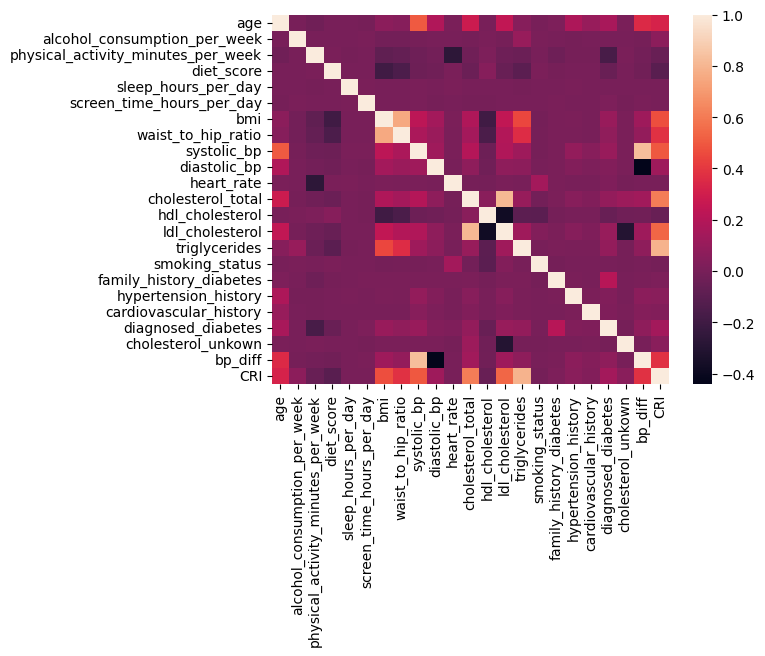

In [6]:
sns.heatmap(df.select_dtypes("number").corr())

In [7]:
df.select_dtypes("number").corr()["diagnosed_diabetes"].sort_values()

physical_activity_minutes_per_week   -0.169789
hdl_cholesterol                      -0.053231
diet_score                           -0.050119
cholesterol_unkown                   -0.005102
smoking_status                        0.000691
alcohol_consumption_per_week          0.002991
sleep_hours_per_day                   0.003509
screen_time_hours_per_day             0.018213
heart_rate                            0.023865
cardiovascular_history                0.024746
hypertension_history                  0.029979
diastolic_bp                          0.036271
bp_diff                               0.076650
waist_to_hip_ratio                    0.081050
cholesterol_total                     0.088112
triglycerides                         0.090635
ldl_cholesterol                       0.102771
bmi                                   0.105580
systolic_bp                           0.107132
CRI                                   0.139184
age                                   0.161162
family_histor

In [8]:
df.nunique().sort_values()

diagnosed_diabetes                      2
cardiovascular_history                  2
hypertension_history                    2
family_history_diabetes                 2
gender                                  3
age_group                               3
smoking_status                          3
bmi_group                               3
heart_group                             3
employment_status                       4
education_level                         4
ethnicity                               5
income_level                            5
alcohol_consumption_per_week            9
waist_to_hip_ratio                     36
diastolic_bp                           54
heart_rate                             60
hdl_cholesterol                        69
sleep_hours_per_day                    69
age                                    71
systolic_bp                            71
cholesterol_unkown                     76
bp_diff                                98
diet_score                        

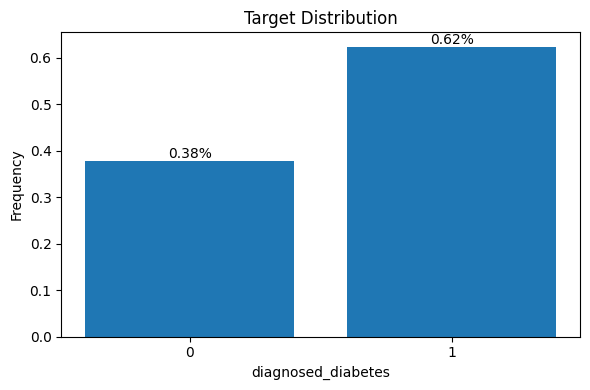

In [9]:
target_dis = df[target].value_counts(normalize=True)
target_dis
fig, ax = plt.subplots(figsize=(6, 4))
target_plot = ax.bar(height= target_dis.values, x=target_dis.index)
ax.set_xticks([0, 1])
ax.bar_label(target_plot, fmt='%.2f%%')
plt.xlabel(target)
plt.ylabel("Frequency")
plt.title("Target Distribution")
plt.tight_layout();

In [10]:
# Create a function to plot.
def plot(data: pd.DataFrame, column_name: str, target= target) -> plt.figure:
    """
    This Create a plot for the particular column.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    column_title_name = column_name.replace("_", " ").title()
        
    # Check the unique value for the column.
    if df[column_name].nunique() < 10:
        # Create a clustered barchart and a pie chart for the column.
        vis = df.groupby([target, column_name])[column_name].value_counts().reset_index()
        
        sns.barplot(x= vis[column_name], y=vis["count"], hue=vis[target], ax=ax1)
        ax1.set_ylabel("Frequency")
        ax1.set_xlabel(column_title_name)
        ax1.set_title(f"Distribution of {column_title_name} against the Diagnose Diabetes")
        
        column_profile = df[column_name].value_counts()
        ax2.pie(column_profile, labels=column_profile.index, autopct="%.2f%%", radius=1)
        ax2.set_title(f"Distribution of {column_title_name}")
        
        plt.suptitle(f"{column_title_name}")
        plt.tight_layout();
    else:
        # Create a boxplot for the column as well as the horizontal barchart for the column
        sns.boxplot(y= df[column_name], x=df[target], ax=ax1)
        ax1.set_ylabel("Range")
        ax1.set_xlabel("Diagnose Diabetes")
        ax1.set_title(f"Distribution of {column_title_name} against the Diagnose Diabetes")

        vis = df[column_name].value_counts().tail(10).sort_values()
        vis.plot(kind="barh", ax=ax2)
        ax2.set_ylabel(column_title_name)
        ax2.set_xlabel("Frequency")
        ax2.set_title(f"Top 10 {column_title_name} Distribution")

        plt.suptitle(f"{column_title_name}")
        plt.tight_layout();

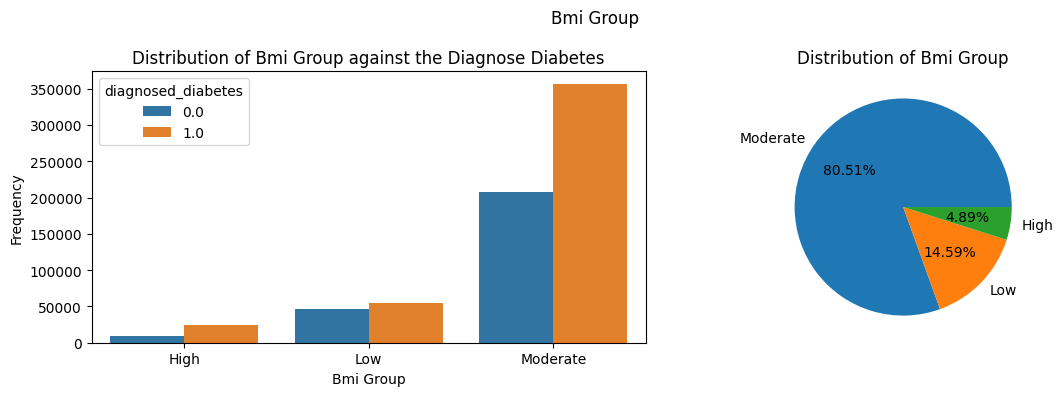

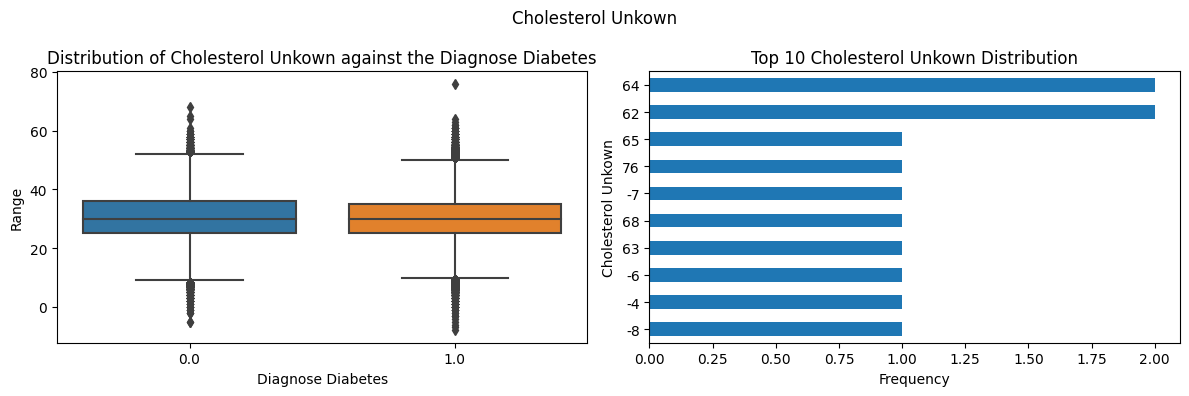

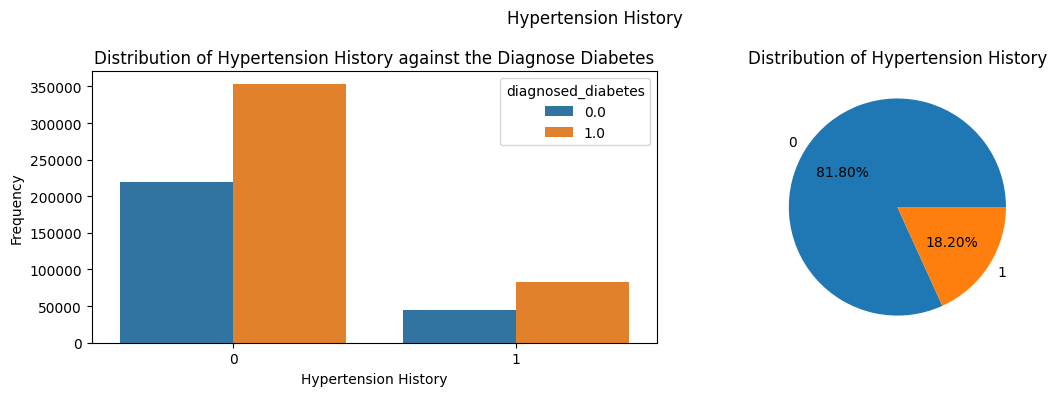

In [11]:
columns = df.drop(columns=target).nunique().index.tolist()
choices = random.choices(columns, k=3)
for choice in choices:
    plot(df, choice)

In [12]:
# Create a function that takes in different model.
def models_score(models:list, df:pd.DataFrame, test_size=test_size, random_state=random_state, test_df=None, target=target):
    # split the data.
    X = df.drop(columns=target)
    y = df[target]
    
    # training and test set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model_score = {}
    # Loop through each the models.
    for model in tqdm(models, desc="Processing"):
        # Create a pipeline.
        model_arch = make_pipeline(
            OneHotEncoder(use_cat_names=True),
            # OrdinalEncoder(),
            StandardScaler(),
            model
        )
        print(f"Training {model}")
        # Train the model.
        model_arch.fit(X_train, y_train)
        
        # Get the last item in the model architecture.
        model_name = list(model_arch.named_steps.keys())[-1]
        # Get the prediction for both the train and test.
        y_train_pred = model_arch.predict_proba(X_train)[:, 1]
        y_test_pred = model_arch.predict_proba(X_test)[:, 1]
    
        roc_train = roc_auc_score(y_train, y_train_pred)
        roc_test = roc_auc_score(y_test, y_test_pred)
        print("Scoring Completed")
        model_score[model_name] = [roc_train, roc_test]

        if test_df is not None:
            test_pred = model_arch.predict_proba(test_df)[:, 1]
            sub_df = pd.DataFrame({"diagnosed_diabetes": test_pred}, index=test_df.index)
            sub_df.to_csv(f"{model_name}.csv")
            print(f"\nSubmission File for {model_name} Created.")
        
    # Create dataframe.
    df = pd.DataFrame(model_score, index=["Traing ROC_AUC Score", 
                                          "Test ROC_AUC Score"]).T
    df = style_column_headers(df)
        
    return df

In [13]:
best_lgb_params = {'n_estimators': 863,
 'learning_rate': 0.03250767662681117,
 'num_leaves': 21,
 'max_depth': 12,
 'min_child_samples': 20}
xgb_params = {'max_depth': 4,
 'learning_rate': 0.14378925549996185,
 'subsample': 0.9577010058460066,
 'colsample_bytree': 0.5607265262597259,
 'n_estimators': 838,
 'min_child_weight': 9,
 'gamma': 0.5636188830534039}
cat_params = {'iterations': 1952, 'depth': 4, 'learning_rate': 0.12778111747886908}
model = [CatBoostClassifier(**cat_params, random_state=random_state,verbose=0),
        # GradientBoostingClassifier(random_state=random_state),
        # AdaBoostClassifier(random_state=random_state),
        XGBClassifier(**xgb_params, random_state=random_state),
        LGBMClassifier(**best_lgb_params, random_state=random_state, verbose=-1)]
models_score(model, df, test_df = test_df)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Training <catboost.core.CatBoostClassifier object at 0x7ac8505f82d0>
Scoring Completed

Submission File for catboostclassifier Created.
Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5607265262597259, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5636188830534039,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14378925549996185,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=838, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Scoring Completed

Submission File for xgbclassif

,Traing ROC_AUC Score,Test ROC_AUC Score
catboostclassifier,0.741898,0.727554
xgbclassifier,0.745122,0.726553
lgbmclassifier,0.733664,0.724378


## Hyper Parameter Tuning.

In [14]:
# from optuna.exceptions import TrialPruned
# def objective(trial):
    
#     # Optuna suggests a value for each hyperparameter in this trial
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'max_depth': trial.suggest_int('max_depth', 5, 15),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
#     }

#     # split the data.
#     X = df.drop(columns=target)
#     y = df[target]
    
#     # training and test set.
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
#     model_arch = make_pipeline(
#             OrdinalEncoder(),
#             StandardScaler(),
#             LGBMClassifier(**param, random_state=random_state, verbose=-1)
#     )
#     # Train the model.
#     model_arch.fit(X_train, y_train)
    
#     # Get the last item in the model architecture.
#     model_name = list(model_arch.named_steps.keys())[-1]
#     # Get the prediction for both the train and test.
#     y_test_pred = model_arch.predict_proba(X_test)[:, 1]
#     y_train_pred = model_arch.predict_proba(X_train)[:, 1]
#     roc_test = roc_auc_score(y_test, y_test_pred)
#     roc_train = roc_auc_score(y_train, y_train_pred)
#     if roc_train - roc_test >= 0.01:
#         raise TrialPruned(f"{roc_test}: Score below threshold — prune trial")
#     else:
#         roc_test = roc_auc_score(y_test, y_test_pred)
#         return roc_test

In [15]:
# study = optuna.create_study(
#     direction="maximize",
#     sampler=optuna.samplers.TPESampler(seed=42), # Use TPE Sampler for efficiency
#     study_name='LGBM_Optuna_Tuning'
# )

In [16]:
# study.optimize(
#     objective, 
#     n_trials=300, 
#     show_progress_bar=True
# )

In [17]:
# best_params = study.best_params
# best_params

In [18]:
# optuna.visualization.plot_param_importances(study)

In [19]:
# optuna.visualization.plot_slice(study)